In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device('cuda')
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device('cpu')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import json
import pickle

import tkinter as tk
import pandas as pd
import cv2
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

CUDA is not available. Using CPU.


import torch: Импортирует библиотеку PyTorch для работы с нейронными сетями.
Определение устройства (device):
Проверяет, доступна ли CUDA (GPU) с помощью torch.cuda.is_available().
Если CUDA доступна, устанавливает device на 'cuda', чтобы использовать GPU.
Иначе, устанавливает device на 'cpu', чтобы использовать CPU.
Импорт библиотек: Импортирует необходимые библиотеки для:
Численных вычислений (numpy).
Визуализации (matplotlib.pyplot).
Работы с файловой системой (os).
Работы с данными в формате JSON (json) и pickle (pickle).
Создания графического интерфейса (tkinter).
Работы с табличными данными (pandas).
Обработки изображений (cv2).
Дополнительных модулей PyTorch (torch.nn, torch.nn.functional, torch.optim, torch.optim.lr_scheduler).

In [3]:
#pip install opencv-python-headless

In [3]:
#pip install torch torchvision torchaudio


In [4]:
#pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu/torchvision-0.17.1%2Bcpu-cp310-cp310-linux_x86_64.whl

# 0.Dataset/Corresponding labels/Classifier

In [3]:
"""
0.0 Reading mov of static image 
"""
###
if_rotate=False # Rotate 90 if needed
###
cap = cv2.VideoCapture("workspace_physical/static.mov")
frame_list=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == True:
        if if_rotate:
            frame=cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        frame_list.append(frame)
    else:
        break
cap.release()

В итоге, этот код читает видеофайл “workspace_physical/static.mov”, извлекает все кадры, возможно, поворачивает их, и сохраняет их в список frame_list.

True

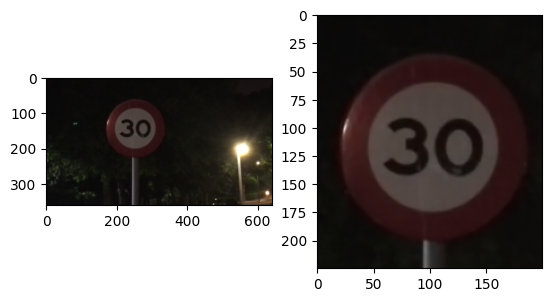

In [4]:
"""
0.1 Select bound for more quality result.
and store victim image 
"""
###
x_bound=(25,250)
y_bound=(150,350)
###

static_img=np.mean(frame_list,axis=0) # mean of multi frames to reduce noise
static_img=np.round(static_img)/255
plt.subplot(1,2,1)
plt.imshow(static_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]][:,:,::-1])

test_img=static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]]
cv2.imwrite('workspace_physical/source.png', (test_img*255).astype("uint8"))

В итоге, этот код усредняет кадры из видео, обрезает область интереса, отображает исходное и обрезанное изображения, и сохраняет обрезанное изображение в файл “workspace_physical/source.png”.

In [5]:
"""
0.2 Reading dictionary of label
"""
###
DATASET="GTSRB"
###
with open("params.json", "r") as config:
    params = json.load(config)
    CLASS_N = params[DATASET]["class_n"]
    LABELS = params[DATASET]["labels"]
    CLASSIFIER_INPUT_SHAPE=params[DATASET]["classifier_input_shape"]
    device = params["device"]

In [6]:
"""
0.3 Reading model of corresponding classifer 
"""
from model import Net
###
CLASSIFIER_MODEL=Net
CLASSIFIER_PATH="model/GTSRB-CNN-2.pth"
###
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

classifier = CLASSIFIER_MODEL(CLASS_N).to(device)
classifier.load_state_dict(
    # torch.load(f'./model/{"adv_" if adv_model else ""}model_lisa.pth',
    torch.load(CLASSIFIER_PATH)
)
print("Classifier Path =", CLASSIFIER_PATH)

CUDA Available:  False
Device: cpu
Classifier Path = model/GTSRB-CNN-2.pth


(128, 128)


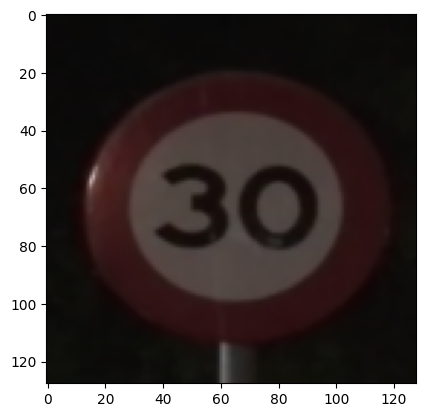

In [7]:
"""
0.4 Read in victim image and corresponding classification 
"""
###
RESIZED_SHAPE=(128,128) # influence the resolution of light generator and ZOO optimizer
###
test_img_ = cv2.imread("workspace_physical/source.png")
test_img = cv2.resize(test_img_, RESIZED_SHAPE, interpolation=cv2.INTER_AREA)
test_img=test_img.astype(np.float32)/255
###
print(test_img[:, :, 0].shape)
plt.imshow(test_img[:, :, ::-1])

Predict: 1: Speed limit 30km/h Confidence: 99.38964247703552%
Top 1 (99.39%) = 1: Speed limit 30km/h ...
Top 2 (0.59%) = 5: Speed limit 80km/h ...
Top 3 (0.01%) = 2: Speed limit 50km/h ...
Top 4 (0.01%) = 6: End of speed limit 80k ...
Top 5 (0.00%) = 4: Speed limit 70km/h ...
Top 6 (0.00%) = 3: Speed limit 60km/h ...
Top 7 (0.00%) = 0: Speed limit 20km/h ...
Top 8 (0.00%) = 7: Speed limit 100km/h ...


/usr/local/python/3.12.1/lib/python3.12/site-packages/torch/nn/functional.py:5082: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


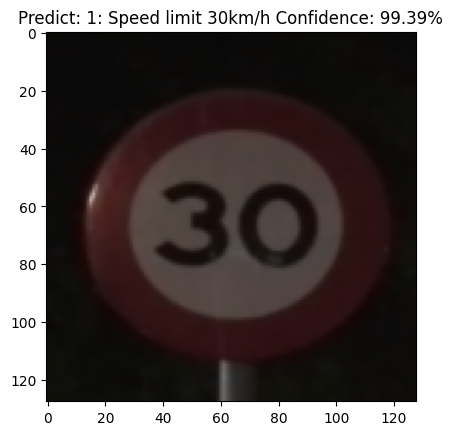

In [8]:
"""
0.5 Prediction of victim classifier and record GROUND TRUTH of victim image 
"""
classifier.eval()
resize_img = cv2.resize(test_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).to(device)
tensor_img = tensor_img.unsqueeze(0)

predict = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index = torch.argmax(predict).item()
confidence = predict[index].item()

###
GROUND_TRUTH = torch.tensor(index).unsqueeze(0)# assumn originally predicted correct
###

print(f"Predict: {LABELS[index]} Confidence: {confidence*100}%")
plt.imshow(test_img[:, :, ::-1])
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))

probs, indices = torch.topk(predict, k=8)
probs = probs.tolist()
indices = indices.tolist()

for i, (indice, p) in enumerate(zip(indices, probs), 1):
    label = LABELS[indice]
    print("Top {} ({:.2f}%) = {}".format(i, p * 100, label[:25]), '...')


# 1.Mask Drawer

In [9]:
"""
1.1 reading target video with lights on victim object
"""
###
SHAPE_RESIZED=(128,128) # influence the resolution of generator and ZOO optimizer
PATH_source="workspace_physical/source.png"
###
source_img = cv2.imread(PATH_source)
source_img = cv2.resize(source_img, SHAPE_RESIZED, interpolation=cv2.INTER_CUBIC)
test_img = source_img.astype(np.float32)/255.0

In [10]:
"""
1.2 record all training target: target_0.mov, target_1.mov ....
"""
import re
target_nums=0
for filename in os.listdir("workspace_physical"):
    pattern_num=re.compile("target_")
    find = re.search(pattern_num, filename)
    if find !=None:
        target_nums+=1
    
print(target_nums)

2


(591, 128, 128, 4)
(591, 128, 128, 3)
(567, 128, 128, 4)
(567, 128, 128, 3)


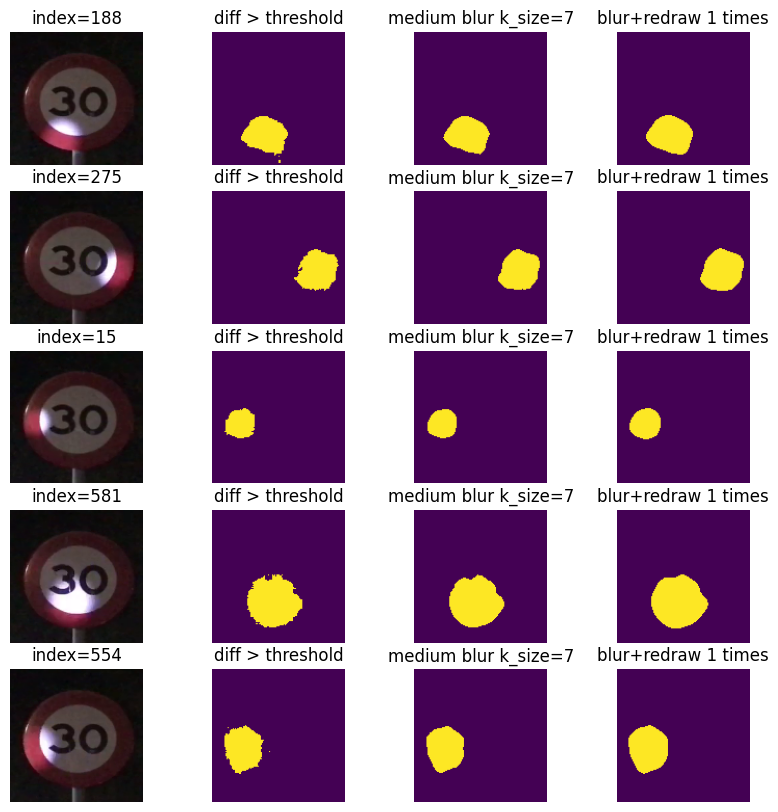

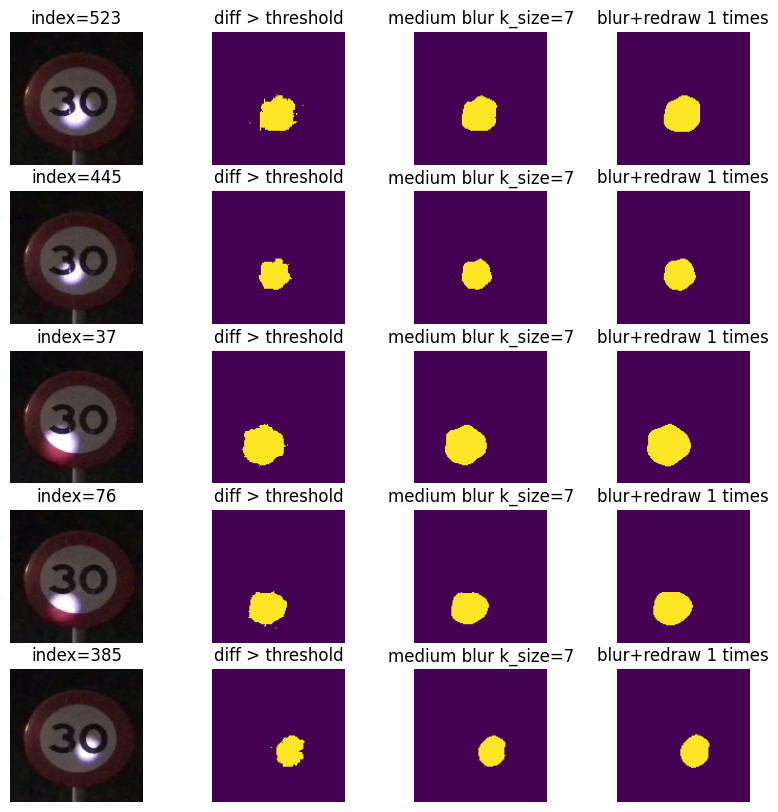

In [11]:
from mask import mask_extract,mask_save,mask_demo
mask_extract(source_img, target_nums, if_rotate,x_bound, y_bound)

In [12]:
"""
1.5 If you satisfy the mask result then concate all existing sub-data you want to train together
"""
mask_save()

Total target(Train) shape= (1158, 128, 128, 3)
Total target( Val ) shape= (127, 128, 128, 3)


# 2. Object-Dependent Light Generator

In [13]:
"""
2.1 Initialize Light Generator 
"""
from model import Generator
###
GENERATOR_MODEL=Generator
GENERATOR_INIT="model/pre_light_generator.pt" # From pre-train stage
###
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

light_generator = GENERATOR_MODEL(gen_input_nc=4, image_nc=3).to(device) # 4 = static+mask
if (GENERATOR_INIT):
     light_generator.load_state_dict(torch.load(GENERATOR_INIT, map_location=torch.device('cpu'))["model_state_dict"])
    

CUDA Available:  False
Device: cpu


In [14]:
"""
2.2 Dataset for training Light Generator 
"""
from light_generator import GAN_dataset
###
PATH_traindata="dataset/physical/train_data.npy"
PATH_traintarget="dataset/physical/train_target.npy"
PATH_valdata="dataset/physical/val_data.npy"
PATH_valtarget="dataset/physical/val_target.npy"
batch_size=16
###
load_augmentation=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
               #torchvision.transforms.RandomRotation(degrees=(-30,30))
                                                 ])   
load_transform = torchvision.transforms.ToTensor()

train_dataset = GAN_dataset(PATH_traindata,PATH_traintarget,load_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataset =  GAN_dataset(PATH_valdata,PATH_valtarget,load_transform)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [15]:
"""
2.3 Learning Module of Light Generator
"""
G_criterion = nn.MSELoss()

lr_G = 0.0002
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

optimizerG = optim.Adam(light_generator.parameters(), lr = lr_G, betas=(beta1, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, 100, gamma=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0047940984..1.0752509].


epoch = 0, G_loss_MSE = 0.00104


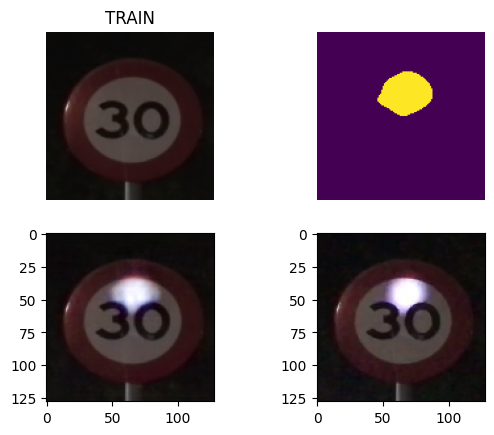

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020092705..1.084361].


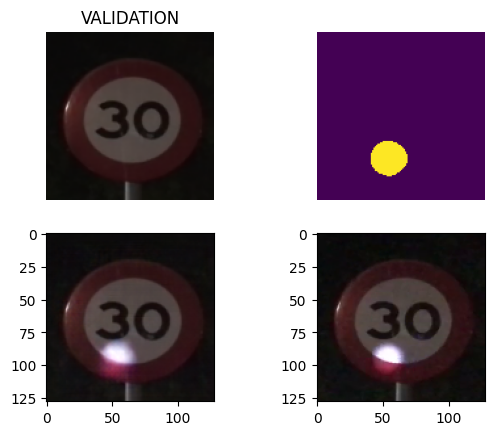

#Validation, G_loss = 0.00119#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026011761..1.1117313].


epoch = 5, G_loss_MSE = 0.00052


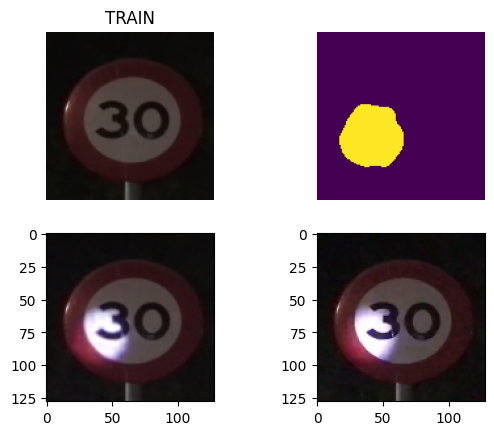

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014676992..1.114645].


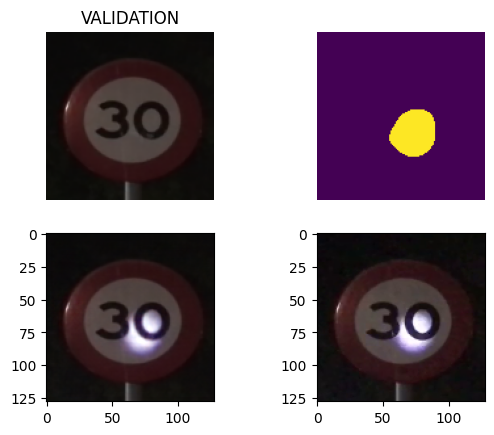

#Validation, G_loss = 0.00050#
epoch = 10, G_loss_MSE = 0.00041


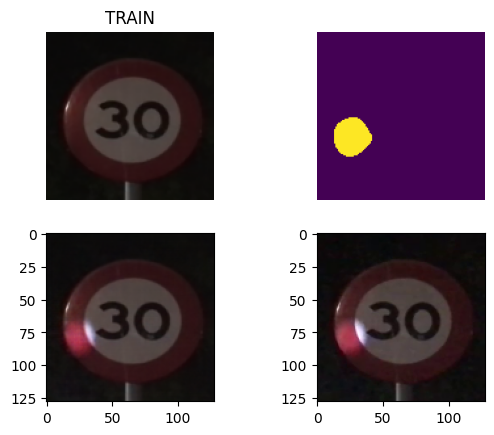

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013268767..0.9285532].


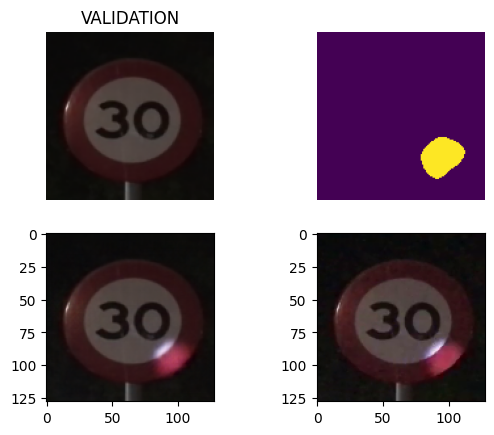

#Validation, G_loss = 0.00043#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026585523..1.1169072].


epoch = 15, G_loss_MSE = 0.00038


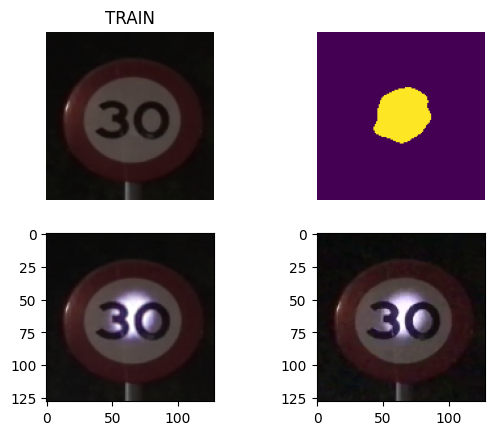

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.4098124e-06..1.1021096].


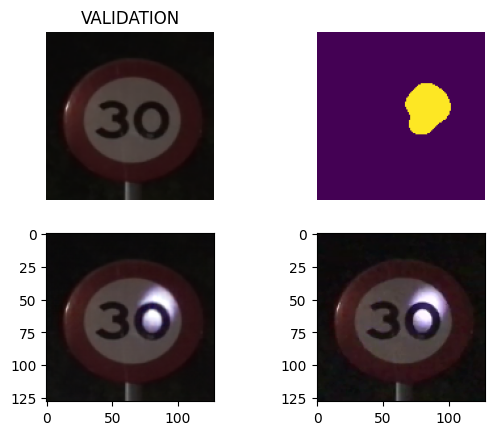

#Validation, G_loss = 0.00040#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019961786..1.0916986].


epoch = 20, G_loss_MSE = 0.00039


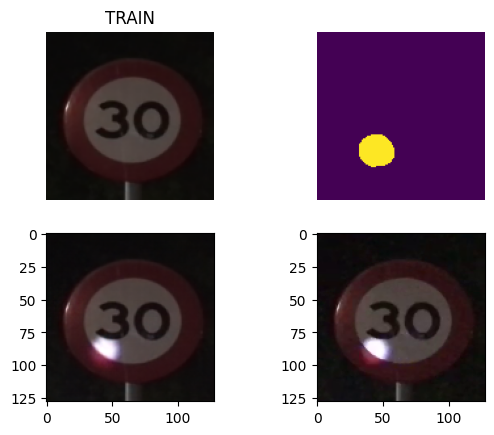

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021829478..1.07999].


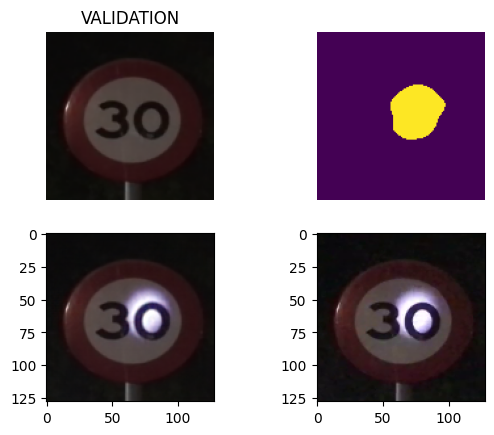

#Validation, G_loss = 0.00037#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0046078265..1.0813562].


epoch = 25, G_loss_MSE = 0.00038


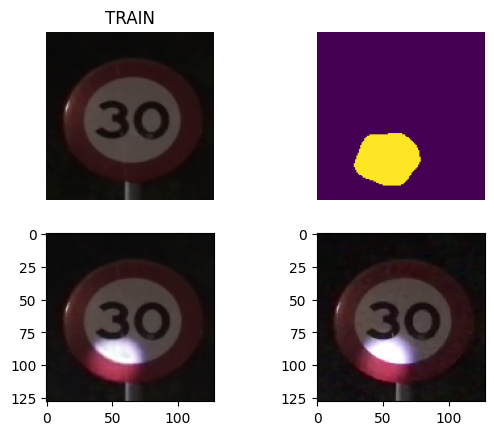

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021837085..1.139713].


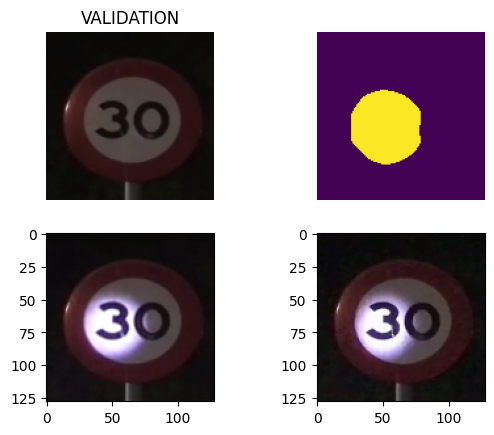

#Validation, G_loss = 0.00046#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0106233..1.1132921].


epoch = 30, G_loss_MSE = 0.00029


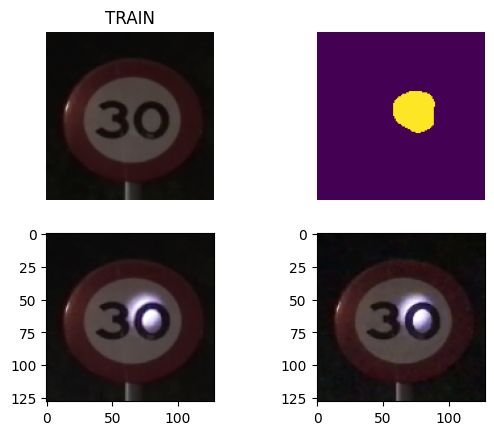

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0036717616..1.026869].


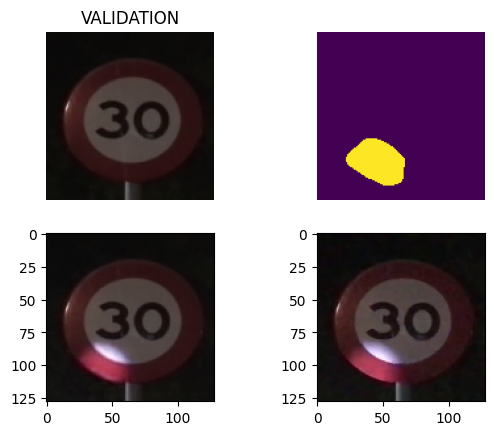

#Validation, G_loss = 0.00037#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0075891074..1.0464035].


epoch = 35, G_loss_MSE = 0.00030


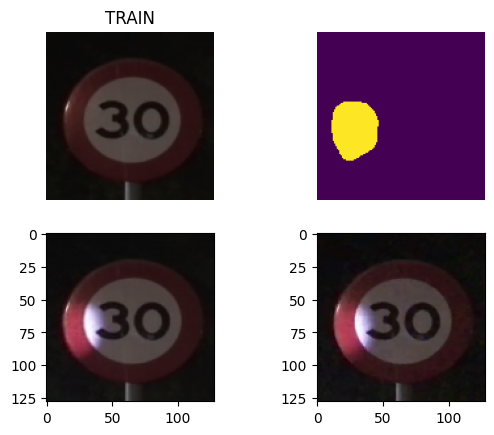

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024414556..1.0701967].


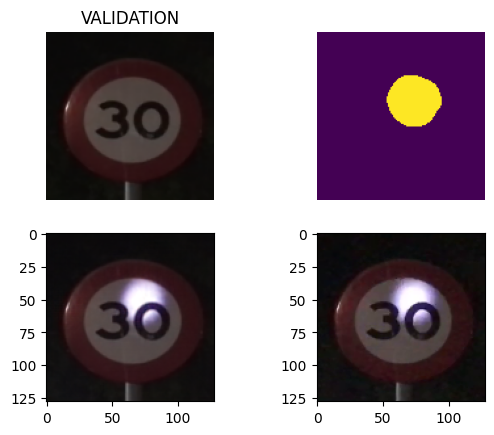

#Validation, G_loss = 0.00032#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.416921e-05..1.0864637].


epoch = 40, G_loss_MSE = 0.00026


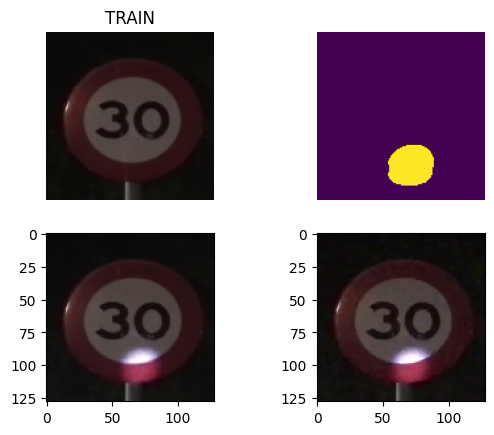

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0035173912..1.0611107].


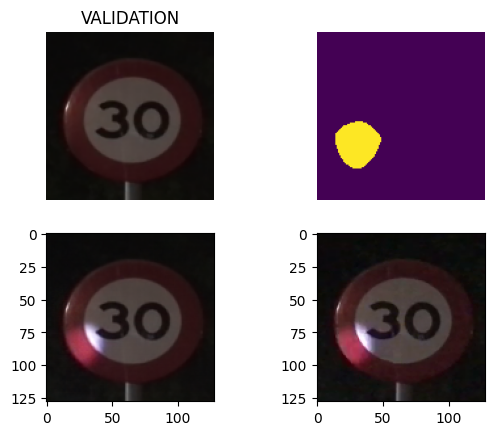

#Validation, G_loss = 0.00032#


In [19]:
from light_generator import train

train(light_generator,optimizerG,schedulerG,G_criterion,train_loader,val_loader,num_epochs=41,Freq_print=5,Freq_plot=5)

[73, 74, 15]


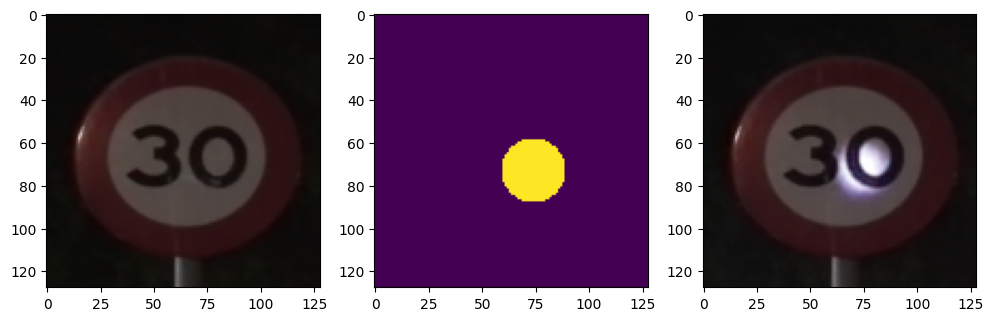

In [16]:
"""
2.5 Demo Light Generator with Random mask
"""
from light_generator import simulate_light_circle,simulate_light_elipse,simulate_light_polygon
###
min_list=[40,40,10] # (x,y,r)
max_list=[80,80,25]
mask_pos=[np.random.randint(min_list[i], max_list[i]) for i in range(len(min_list))]
print(mask_pos)
###


light_generator=GENERATOR_MODEL(gen_input_nc=4, image_nc=3).to(device)
light_generator.load_state_dict(torch.load("model/light_generator.pt", map_location=torch.device('cpu'))["model_state_dict"])
sim,mask=simulate_light_circle(light_generator, source_img, mask_pos)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(source_img[:,:,::-1])

plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
plt.imshow(sim[:,:,::-1])

In [17]:
print(source_img)

[[[ 9 10 11]
  [ 9 10 10]
  [ 9 10 10]
  ...
  [ 9 10 10]
  [10 10 10]
  [ 9 10 11]]

 [[10 10 11]
  [ 9 10 11]
  [ 9 10 10]
  ...
  [10 10 11]
  [ 9  9 10]
  [ 9 10 10]]

 [[ 9 11 11]
  [ 9 11 10]
  [ 9 10 10]
  ...
  [10 10 10]
  [ 9 10 10]
  [10 10 10]]

 ...

 [[ 9 14 13]
  [10 15 14]
  [10 16 15]
  ...
  [10 12 13]
  [10 12 13]
  [10 13 14]]

 [[10 15 14]
  [ 9 15 14]
  [ 9 14 14]
  ...
  [10 12 14]
  [11 12 14]
  [11 13 14]]

 [[10 15 14]
  [10 14 14]
  [ 9 14 13]
  ...
  [10 13 14]
  [11 13 14]
  [10 13 14]]]


# 3.ZOO attack optimizer

In [18]:
from optimize import ZeroOrderOptimizer

###
test_img
criteria = nn.CrossEntropyLoss()
label_attack = GROUND_TRUTH[0]

#############################################################
pos_min_list=[0.3*RESIZED_SHAPE[0], 0.3*RESIZED_SHAPE[1],30] # specify lower bound of each dimension (x1,y1,x2,y2,x3,y3)
pos_max_list=[0.7*RESIZED_SHAPE[0], 0.7*RESIZED_SHAPE[1],10] # specify upper bound of each dimension
###
ZOO_optimizer = ZeroOrderOptimizer(
    source_img, # victim image
    iter=6, # optimize iter of each start point
    label=GROUND_TRUTH.squeeze(),
    attack_model=classifier,
    light_generator=light_generator,
    criteria=criteria, # score criteria
    point_num=5, # number of start point
    draw_light=simulate_light_circle, # draw mask from pos-space to x,y plabe
    min_list=pos_min_list, # lower bound of pos-space
    max_list=pos_max_list, # upper bound of pos-space
    classifier_input_shape=CLASSIFIER_INPUT_SHAPE,
    LABELS=LABELS,
    grad_step=1, # step size to approximate grad(smoothing parameter in ZOO term)
    lr_step=3, # optimize step based on grad
    threshold_restart=0.001 # converge restart threshold
)

Представь, что ты хочешь обмануть учителя, чтобы он не узнал тебя на фотографии. Но ты не можешь замазать лицо или надеть маску. Ты можешь только немного изменить освещение на фотографии.

**Задача:** Найти, где и какого размера поставить "фонарик" на картинке, чтобы нейросеть (наш "учитель") перестала узнавать на ней нужный объект.

**Как это делается:**

1. **"Кандидаты" (Point):** У нас есть несколько "хулиганов" (Point), каждый из которых пытается по-своему обмануть нейросеть. Каждый "хулиган" выбирает случайное место и размер для своего "фонарика".

2. **"Фонарик" (simulate_light_circle):** Каждый "хулиган" берёт картинку и с помощью специальной функции (simulate_light_circle) рисует на ней круг света (наш "фонарик") в выбранном месте и заданного размера.

3. **"Обман" (light_inference):** Теперь нужно проверить, получилось ли обмануть нейросеть. Мы показываем нейросети картинку с "фонариком" и смотрим, что она скажет.

   * Если нейросеть ошиблась (не узнала объект), значит "хулиган" был близок к цели!
   * Если нейросеть всё ещё узнаёт объект, значит "фонарик" нужно подвинуть или изменить его размер.

4. **"Подсказки" (find_grad):** Чтобы понять, куда двигать "фонарик", каждый "хулиган" делает небольшие пробные шаги:

   * Чуть-чуть двигает "фонарик" вправо и смотрит, стало лучше или хуже обманывать нейросеть.
   * Чуть-чуть двигает "фонарик" влево и смотрит, стало лучше или хуже.
   * И так далее для движения вверх, вниз, и изменения размера "фонарика".

   Сравнивая результаты, "хулиган" понимает, в какую сторону нужно двигать "фонарик", чтобы обмануть нейросеть. Это похоже на то, как ты ищешь выход из лабиринта, пробуя разные пути.

5. **"Движение" (update_pos):** "Хулиган" делает небольшой шаг в направлении, которое, по его мнению, поможет обмануть нейросеть. Он двигает "фонарик" и немного меняет его размер.

6. **Повторение (run):** Шаги 2-5 повторяются много раз. Каждый "хулиган" пробует разные места и размеры для своего "фонарика", пока один из них не сможет успешно обмануть нейросеть.

7. **"Усталость" (threshold_restart):** Иногда "хулиган" застревает в плохом месте, где никак не получается обмануть нейросеть. Тогда он решает начать всё сначала и выбирает новое случайное место для своего "фонарика".

**Главная идея:**

*   Мы не знаем, как именно работает нейросеть и какие места на картинке для неё самые важные.
*   Поэтому мы пробуем разные варианты "фонариков" и смотрим, какие из них заставляют нейросеть ошибаться.
*   Мы используем небольшие пробные шаги, чтобы понять, в какую сторону нужно двигать "фонарик", чтобы увеличить вероятность обмана.

В итоге, с помощью проб и ошибок, мы находим такое положение и размер "фонарика", которое сбивает нейросеть с толку и заставляет её ошибаться. И всё это без знания внутренней работы нейросети!


In [19]:
ZOO_optimizer.run()

2: Speed limit 50km/h
Confidence: 99.87379908561707 %
best pos [np.int16(75), np.int16(52), np.int16(10)]
Largest Loss 7.449067115783691


True

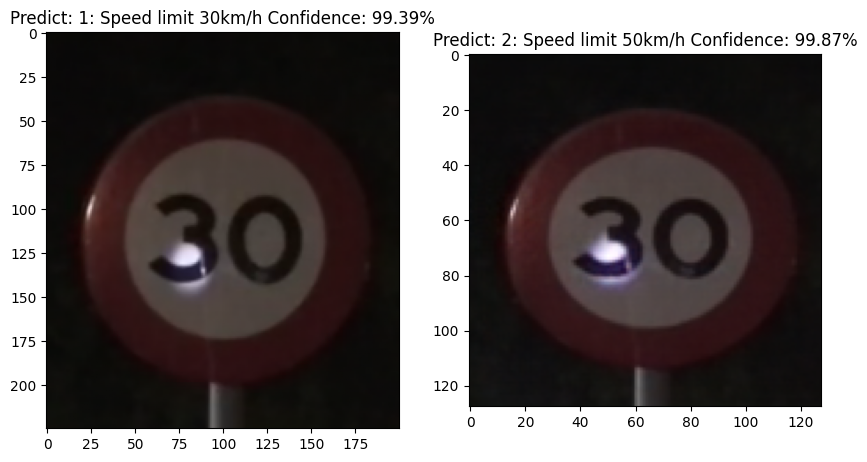

In [32]:
"""
3.5 Demo of ZOO optimize result 
"""
print(LABELS[ZOO_optimizer.predict])
print(f"Confidence: {ZOO_optimizer.confidence.item()*100} %")
print("best pos", ZOO_optimizer.global_best_pos)
print("Largest Loss",ZOO_optimizer.global_best_value)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))
plt.imshow(test_img[:,:,::-1])

plt.subplot(122)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[ZOO_optimizer.predict], ZOO_optimizer.confidence.item()*100))
plt.imshow(ZOO_optimizer.attack_img[:,:,::-1])

cv2.imwrite('workspace/sim_light.png', (ZOO_optimizer.attack_img*255).clip(0,255).astype("uint8"))

2: Speed limit 50km/h
Confidence: 99.87379908561707 %
best pos [np.int16(75), np.int16(52), np.int16(10)]
Largest Loss 7.449067115783691


True

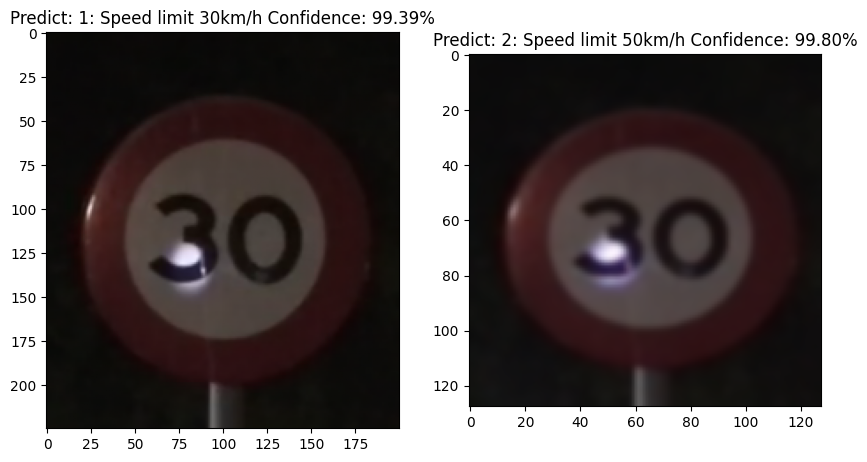

In [ ]:
"""
3.5 Demo of ZOO optimize result + ГАУСС
"""
import matplotlib.pyplot as plt
import cv2
import numpy as np

print(LABELS[ZOO_optimizer.predict])
print(f"Confidence: {ZOO_optimizer.confidence.item()*100} %")
print("best pos", ZOO_optimizer.global_best_pos)
print("Largest Loss",ZOO_optimizer.global_best_value)

# Apply Gaussian blur to the attacked image
blurred_attack_img = cv2.GaussianBlur(ZOO_optimizer.attack_img, (5, 5), 0) # kernel size 5x5, sigma=0

# Re-evaluate with the blurred image
classifier.eval()
resize_img = cv2.resize(blurred_attack_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).unsqueeze(0).to(device)

predict_blurred = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index_blurred = torch.argmax(predict_blurred).item()
confidence_blurred = predict_blurred[index_blurred].item()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))
plt.imshow(test_img[:,:,::-1])

plt.subplot(122)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index_blurred], confidence_blurred*100))
plt.imshow(blurred_attack_img[:,:,::-1])

cv2.imwrite('workspace/sim_light.png', (ZOO_optimizer.attack_img*255).clip(0,255).astype("uint8"))
cv2.imwrite('workspace/blurred_sim_light.png', (blurred_attack_img*255).clip(0,255).astype("uint8")[:,:,::-1])

2: Speed limit 50km/h
Confidence: 99.87379908561707 %
best pos [np.int16(75), np.int16(52), np.int16(10)]
Largest Loss 7.449067115783691


True

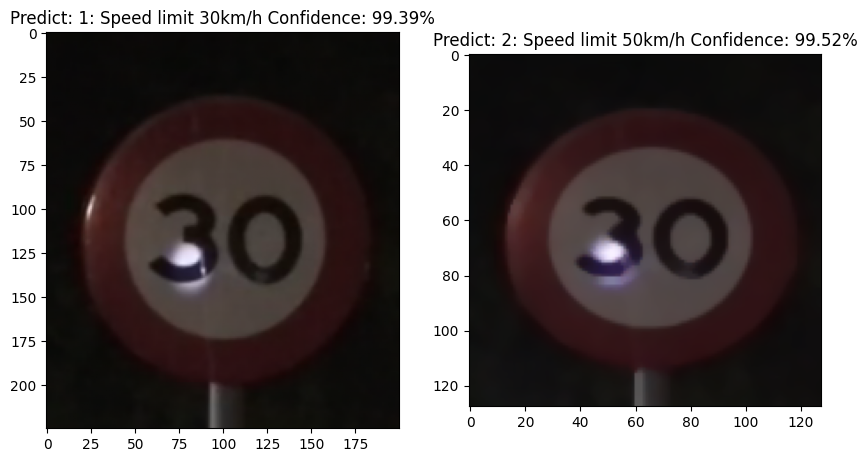

In [34]:
"""
3.5 Demo of ZOO optimize result + МЕДИАННЫЙ
"""
import matplotlib.pyplot as plt
import cv2
import numpy as np

print(LABELS[ZOO_optimizer.predict])
print(f"Confidence: {ZOO_optimizer.confidence.item()*100} %")
print("best pos", ZOO_optimizer.global_best_pos)
print("Largest Loss",ZOO_optimizer.global_best_value)

# Apply Median blur to the attacked image
blurred_attack_img = cv2.medianBlur(ZOO_optimizer.attack_img, 5) # kernel size 5

# Re-evaluate with the blurred image
classifier.eval()
resize_img = cv2.resize(blurred_attack_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).unsqueeze(0).to(device)

predict_blurred = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index_blurred = torch.argmax(predict_blurred).item()
confidence_blurred = predict_blurred[index_blurred].item()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))
plt.imshow(test_img[:,:,::-1])

plt.subplot(122)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index_blurred], confidence_blurred*100))
plt.imshow(blurred_attack_img[:,:,::-1])

cv2.imwrite('workspace/sim_light.png', (ZOO_optimizer.attack_img*255).clip(0,255).astype("uint8"))
cv2.imwrite('workspace/median_blurred_sim_light.png', (blurred_attack_img*255).clip(0,255).astype("uint8")[:,:,::-1])

True

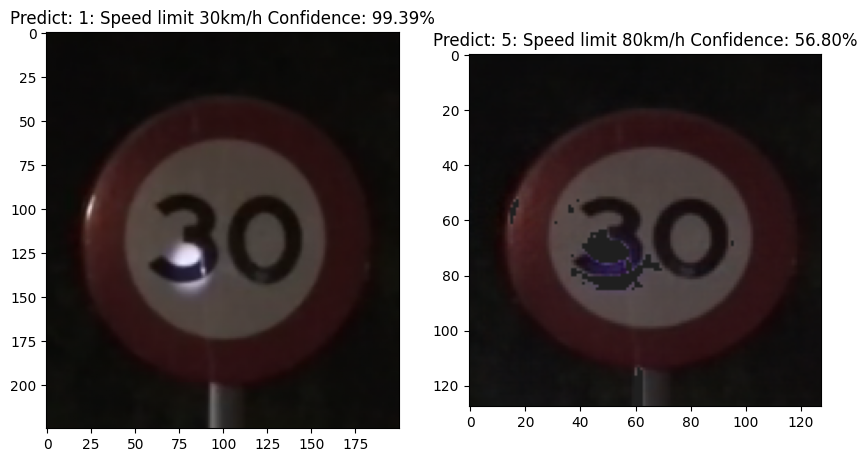

In [41]:
"""
3.5 Demo of ZOO optimize result 
"""
import matplotlib.pyplot as plt
import cv2
import numpy as np


# 1. Convert to grayscale
gray_attack_img = cv2.cvtColor(ZOO_optimizer.attack_img, cv2.COLOR_BGR2GRAY)

# 2. Calculate the mean intensity of the entire image
mean_intensity = np.mean(gray_attack_img)

# 3. Find the brightest pixels (e.g., top 10% brightest)
threshold_intensity = np.percentile(gray_attack_img, 98) # Adjust 90% as needed
bright_pixels = gray_attack_img > threshold_intensity

# 4. Replace bright pixels with the mean intensity
modified_attack_img = ZOO_optimizer.attack_img.copy() # Create a copy to modify
modified_attack_img[bright_pixels] = mean_intensity # Corrected indexing

# Re-evaluate with the modified image
classifier.eval()
resize_img = cv2.resize(modified_attack_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).unsqueeze(0).to(device)

predict_modified = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index_modified = torch.argmax(predict_modified).item()
confidence_modified = predict_modified[index_modified].item()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))
plt.imshow(test_img[:,:,::-1])

plt.subplot(122)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index_modified], confidence_modified*100))
plt.imshow(modified_attack_img[:,:,::-1])

cv2.imwrite('workspace/sim_light.png', (ZOO_optimizer.attack_img*255).clip(0,255).astype("uint8"))
cv2.imwrite('workspace/modified_sim_light.png', (modified_attack_img*255).clip(0,255).astype("uint8")[:,:,::-1])


2: Speed limit 50km/h
Confidence: 99.87379908561707 %
best pos [np.int16(75), np.int16(52), np.int16(10)]
Largest Loss 7.449067115783691


True

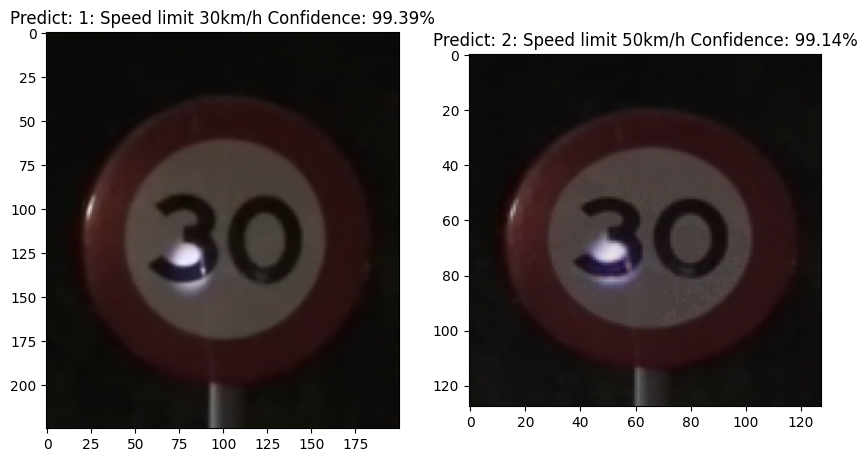

In [43]:
"""
3.5 Demo of ZOO optimize result 
"""
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

print(LABELS[ZOO_optimizer.predict])
print(f"Confidence: {ZOO_optimizer.confidence.item()*100} %")
print("best pos", ZOO_optimizer.global_best_pos)
print("Largest Loss",ZOO_optimizer.global_best_value)

# 1. Convert to grayscale
gray_attack_img = cv2.cvtColor(ZOO_optimizer.attack_img, cv2.COLOR_BGR2GRAY)

# 2. Calculate the mean intensity of the entire image
#mean_intensity = np.mean(gray_attack_img) #Not used, since we decrease
                                            #brightness rather than replacing
                                            #with the mean

# 3. Find the brightest pixels (e.g., top 10% brightest)
threshold_intensity = np.percentile(gray_attack_img, 90) # Adjust 90% as needed
bright_pixels = gray_attack_img > threshold_intensity

# 4. Replace bright pixels with decreased intensity
modified_attack_img = (ZOO_optimizer.attack_img*255).copy().astype(np.float32)  # Create a copy to modify, use float for subtraction
intensity_decrease = 0.1  # 10% decrease
modified_attack_img[bright_pixels] = modified_attack_img[bright_pixels] * (1 - intensity_decrease)

# Clip values to be within the valid range [0, 255]
modified_attack_img = np.clip(modified_attack_img, 0, 255)

modified_attack_img = modified_attack_img.astype(np.uint8) #change back to uint8

# Re-evaluate with the modified image
classifier.eval()
resize_img = cv2.resize(modified_attack_img/255, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC) #normalized before resizing

# Ensure the numpy array is float32 before converting to tensor
resize_img = resize_img.astype(np.float32)
tensor_img = torchvision.transforms.ToTensor()(resize_img).unsqueeze(0).to(device)


# Ensure the tensor is float before passing to the classifier
tensor_img = tensor_img.float()

predict_modified = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index_modified = torch.argmax(predict_modified).item()
confidence_modified = predict_modified[index_modified].item()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))
plt.imshow(test_img[:,:,::-1])

plt.subplot(122)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index_modified], confidence_modified*100))
plt.imshow(modified_attack_img[:,:,::-1])

cv2.imwrite('workspace/sim_light.png', (ZOO_optimizer.attack_img*255).clip(0,255).astype("uint8"))
cv2.imwrite('workspace/modified_sim_light.png', modified_attack_img[:,:,::-1])

# 4. Into Physical

True

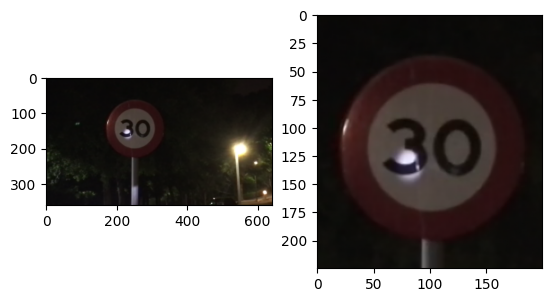

In [23]:
# !!! Due to the run to run variance your result might differ.
"""
4.1 video to image reduce noise(or skip this part use png only) 
"""
cap = cv2.VideoCapture("workspace_physical/physical.mov")
frame_list=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == True:
        if if_rotate:
            frame=cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        frame_list.append(frame)
    else:
        break
cap.release()

static_img=np.mean(frame_list,axis=0) # mean of multi frames to reduce noise
static_img=np.round(static_img)/255
plt.subplot(1,2,1)
plt.imshow(static_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]][:,:,::-1])

test_img=static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]]
cv2.imwrite('workspace_physical/physical.png', (test_img*255).astype("uint8"))

Text(0.5, 1.0, '2: Speed limit 50km/h... Confidence: 99.90%')

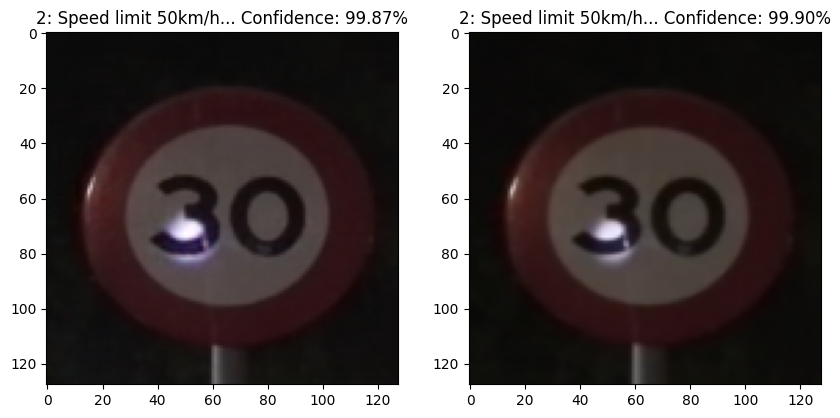

In [25]:
"""
4.2 Inference physical image to evaluate simulation and physical attack 
"""
###
physical_img_ = cv2.imread("workspace_physical/physical.png")
###
physical_img = cv2.resize(physical_img_, RESIZED_SHAPE, interpolation=cv2.INTER_AREA)
physical_img=physical_img.astype(np.float32)/255

classifier.eval()
resize_img = cv2.resize(physical_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).unsqueeze(0).to(device)

predict_phy = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index_phy = torch.argmax(predict_phy).item()
confidence_phy = predict_phy[index_phy].item()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("{}... Confidence: {:.2f}%".format(LABELS[ZOO_optimizer.predict][:25], ZOO_optimizer.confidence.item()*100))
plt.imshow(ZOO_optimizer.attack_img[:,:,::-1])

plt.subplot(122)
plt.imshow(physical_img[:,:,::-1])
plt.title("{}... Confidence: {:.2f}%".format(LABELS[index_phy][:25],confidence_phy*100))